In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy
import sklearn
from sklearn.preprocessing import OneHotEncoder

# Quiet setting warnings
pd.options.mode.chained_assignment = None

#StratifiedKFold
#n_folds
#Every fold needs to have unchanged data go in - fit scalar on training; apply to training and test
#fit -> transform
#How does fold size effect ROC curve?
#MinMax - need uniform distribution

In [6]:
# Import data
WORK_DIR = os.getcwd()
filename = 'CardiacHypertrophyData_50Samples.xlsx'
data50_df = pd.read_excel(f'{WORK_DIR}/{filename}')
data50_df.head()

,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,59.053851,Male,Asian,0.625929,71.025200,98.960236,0
1,56.291312,Male,White,0.632001,51.666039,112.938934,0
2,66.216488,Male,White,0.601147,105.635574,98.363388,1
3,45.684119,Female,Black or African American,0.546039,96.767563,104.544754,0
4,69.492794,Female,White,0.677071,86.660133,129.907806,1


# EDA

## Missing Data
No missing data in this data set

In [7]:
data50_df.isnull().sum()

Age                        0
Sex                        0
Racial group               0
Ejection fraction          0
Heart rate (bpm)           0
Systolic blood pressure    0
Pathologic?                0
dtype: int64

In [4]:
def num_feature_dist_plot(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in X.columns if feature not in numeric_features]
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(X[feature]))
        counts = [list(X[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    

## Feature Visualization

In [14]:
def X_y_split(df, target, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

In [15]:
X, y = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)

### Numeric Features

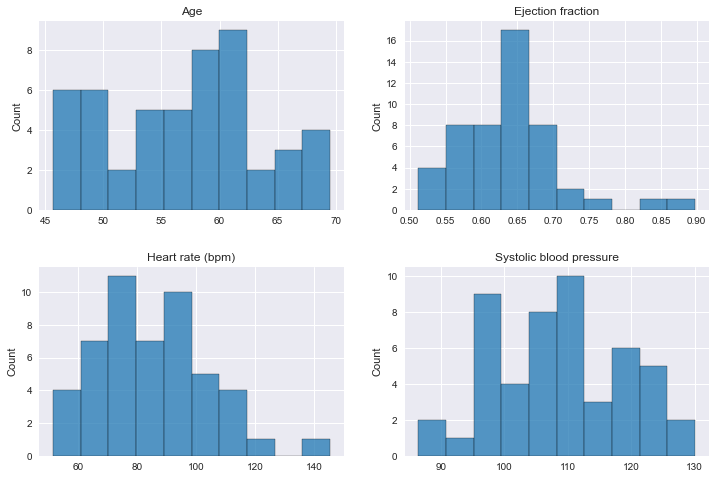

In [11]:
num_feature_dist_plot(df=X, n_col=2, fig_width=12, fig_height=8, bins=10, hspace=0.3, wspace=0.2)

### Categorical Features

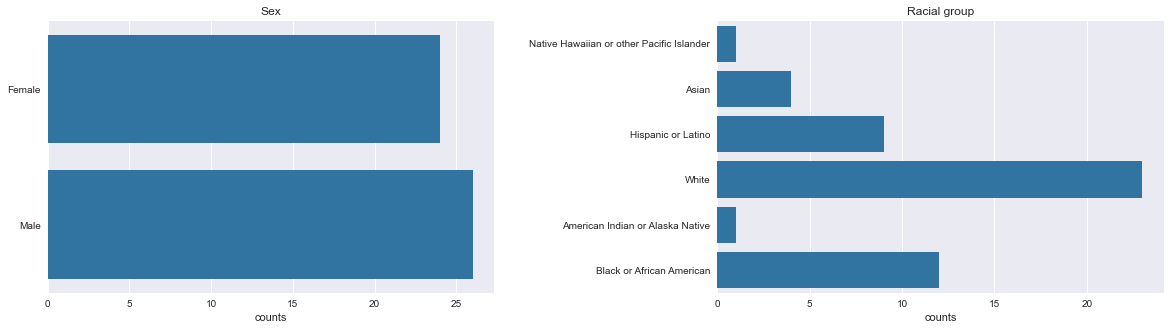

In [12]:
cat_feature_count_plot(df=X, n_col=2, fig_width=20, fig_height=5, hspace=0, wspace=0.5)

## Outcome Visualization

Text(0, 0.5, '')

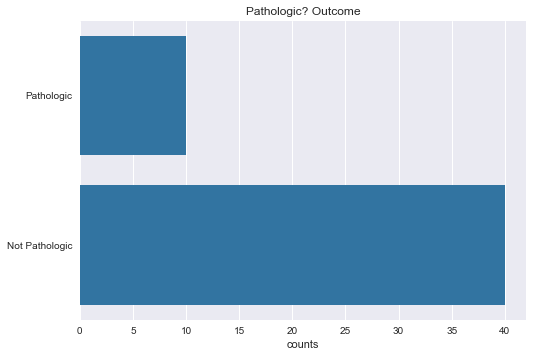

In [13]:
# Encode outcome var
yVis = y.copy()
yVis = yVis.map({0: 'Not Pathologic', 1: 'Pathologic'})

# Set count df for plot
labels = list(set(yVis))
counts = [list(yVis).count(c) for c in labels]
plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                        'counts': counts})    
        
# Plot
fig, ax = plt.subplots()
sns.barplot(data=plot_df, y="labels", x="counts", color="tab:blue")
ax.set_title('Pathologic? Outcome', fontsize=12)
ax.set_ylabel('')

# Data Pre-Processing

In [16]:
X, y = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)

## Categorical Variable Encoding

In [39]:
def encodeCategories(X):
    '''
    Function to encode categorical features
    Features with two categories will be encoded as binary
    Features with more than two categories will be one-hot-encoded
    '''
    # Copy df 
    df = X.copy()
    categorialColumnNames_list = df.select_dtypes(include=['object']).columns.values.tolist()
    featureCategoryCount_dict = {feature: len(set(df[feature])) for feature in categorialColumnNames_list}

    # Encode feature based on number of categories
    for feature, categoryCount in featureCategoryCount_dict.items():

        # Convert binary feature to binary 0, 1
        if categoryCount == 2:

            # Encode column
            feat0, feat1 = tuple(set(df[feature]))
            df[feature] = df[feature].map({feat0: 0, feat1: 1})

            # Display which category is encoded 0 and 1
            print(feature + ' encoded as binary')
            print(f'   0: {feat0}')
            print(f'   1: {feat1}\n')

        # One-hot-encode feature with more than 2 categories
        elif categoryCount > 2:

            # Code adapted from Antonio Perez, PhD
            # Encode column
            encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoder.fit(df[feature].to_numpy().reshape(-1, 1))
            encodedData = encoder.transform(df[feature].to_numpy().reshape(-1, 1))

            # Copy to data frame
            for i in range(encodedData.shape[1]):
                if type(encoder.categories_[0][i]) == str:
                    df[f'{feature}_{encoder.categories_[0][i]}'] = encodedData[:, i]

            # Drop original column
            df.pop(feature)

            # Display message
            print(f'{feature} one-hot-encoded')

        # Safe gaurd against features with only one category
        else:
            pass
        
    return df


In [41]:
X = encodeCategories(X)
X.head(5)

,Age,Sex,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Racial group_American Indian or Alaska Native,Racial group_Asian,Racial group_Black or African American,Racial group_Hispanic or Latino,Racial group_Native Hawaiian or other Pacific Islander,Racial group_White
0,59.053851,1,0.625929,71.025200,98.960236,0.0,1.0,0.0,0.0,0.0,0.0
1,56.291312,1,0.632001,51.666039,112.938934,0.0,0.0,0.0,0.0,0.0,1.0
2,66.216488,1,0.601147,105.635574,98.363388,0.0,0.0,0.0,0.0,0.0,1.0
3,45.684119,0,0.546039,96.767563,104.544754,0.0,0.0,1.0,0.0,0.0,0.0
4,69.492794,0,0.677071,86.660133,129.907806,0.0,0.0,0.0,0.0,0.0,1.0
